# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [132]:
!unzip data.zip

Archive:  data.zip
  inflating: lenta_sample.csv        
  inflating: __MACOSX/._lenta_sample.csv  


In [133]:
!pip install pandas scikit-learn matplotlib

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


## Рекуррентные нейронные сети

Рекуррентные нейронные сети (RNN) предназначены для работы с последовательностями (в том числе текстом). По устройству они похожи на цикл, где каждый шаг связан с предудущим. Работают RNN сильно дольше сверток, так как сверточные слои применяются независимо и можно параллельно вычислить все трансформации, а в RNN вычислять шаг можно только после того, как вычеслен предыдущий. Неэффективность, как правило, компенсируется точностью, поэтому RNN являются стандартным инструментом при работе с текстами.

## Классификация текста с помощью RNN

Давайте посмотрим, как в тензорфлоу использовать рекуррентные слои и как их соединять с Embedding и Dense слоями.

Используем данные, что и в двух предыдущих занятиях.

## Код с прошлых занятий

In [3]:
import tensorflow as tf

In [4]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data = pd.read_csv('lenta_sample.csv')

Предобработка нам тут особо не важна.

In [6]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

В предыдущей домашке не хватало фмеры. Ее нет в керасе, но можно взять вот такую функцию (взятую со стаковерфлоу)

In [7]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Предобработка точно такая же

In [8]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [9]:
len(vocab)

670782

In [10]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [11]:
len(filtered_vocab)

55293

In [12]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [13]:
id2word = {i:word for word, i in word2id.items()}

In [14]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [15]:
MAX_LEN = max(len(x) for x in X)

Можно посчитать среднюю или медианную длину, если максимальная кажется слишком большой.

In [16]:
MEAN_LEN = np.median([len(x) for x in X])

In [17]:
MAX_LEN, MEAN_LEN

(3578, 170.0)

In [18]:
MAX_LEN = int(MEAN_LEN + 30)

In [19]:
# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [20]:
X.shape

(147852, 200)

In [21]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [22]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [23]:
len(label2id)

19

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [24]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

## Конец кода с прошлых занятий

Есть несколько разновидностей рекуррентных слоев - RNN (vanila rnn), GRU, LSTM. 

Первый - самый простой рекуррентный слой, где на каждом шаге используется предыдущее состояние и текущий вектор, оба они умножаются на соответствующую матрицу весов и получившиеся вектора складываются в один, который передается на следующий шаг. Проблема с обычными RNN в том, что информация о предыдущих состояних очень быстро затирается и учитывать нелокальные зависимости не получается. 



LSTM и GRU частично решают это проблему добавление дополнительных матриц весов и активаций, которые будут отвечать за то, чтобы нужная информация сохранялась на протяжении всей последовательности. GRU немного проще и поэтому немного быстрее, но это не всегда значит, что LSTM лучше по качеству. 


In [135]:
# lstm cell
Image(url="https://habrastorage.org/webt/xt/_q/nj/xt_qnjgfjengqoqd4gizkq4j_wk.png",
     width=1000, height=1000)

Ссылки, чтобы разобраться подробнее:  
    http://karpathy.github.io/2015/05/21/rnn-effectiveness/  
    https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21  
    https://colah.github.io/posts/2015-08-Understanding-LSTMs/  
    
    
    
    

Использовать RNN слой в tf проще, чем понять, как он устроен. Нужно просто поставить его после другого слоя, который возвращает последовательность.

При return_sequences=False в следующий слой будет передаваться только последнее состояние - 1 вектор, т.е. не нужно конкатенировать

In [25]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )


rnn = tf.keras.layers.SimpleRNN(128, return_sequences=False)(embeddings)
# lstm = tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)
# lstm = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

dense = tf.keras.layers.Dense(64, activation='relu')(rnn)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 30)           1658820   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               20352     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 19)                1235      
Total params: 1,688,663
Trainable params: 1,688,663
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
141/141 [==============================] - 38s 252ms/step - loss: 2.4573 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3023 - val_f1: 0.0000e+00 - val_rec@prec: 1.3526e-04
Epoch 2/10
141/141 [==============================] - 34s 244ms/step - loss: 2.2937 - f1: 7.1608e-04 - rec@prec: 3.0274e-05 - val_loss: 2.2270 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
141/141 [==============================] - 34s 244ms/step - loss: 2.1441 - f1: 0.0257 - rec@prec: 0.0051 - val_loss: 2.6422 - val_f1: 0.1091 - val_rec@prec: 0.0022
Epoch 4/10
141/141 [==============================] - 35s 245ms/step - loss: 1.9770 - f1: 0.1697 - rec@prec: 0.0511 - val_loss: 1.7452 - val_f1: 0.3120 - val_rec@prec: 0.0902
Epoch 5/10
141/141 [==============================] - 34s 244ms/step - loss: 1.5627 - f1: 0.3903 - rec@prec: 0.1884 - val_loss: 1.9638 - val_f1: 0.1955 - val_rec@prec: 0.0667
Epoch 6/10
141/141 [==============================] - 34s 241ms/step - loss: 1.5304 - f1: 0.3

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


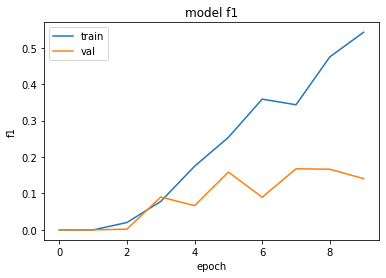

In [29]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Рекуррентные слои можно накладывать друг на друга. Нужно только указать параметр return_sequences=True, т.к. слой ожидает на вход последовательность. Длина последовательности не изменяется, поэтому можно совмещать сколько угодно слоев.

Основной параметр в LSTM/GRU слое - units. Чем он больше, тем больше весов будет в модели. Он будет соответствовать размеру вектора состояния. Он может быть любой даже при накладывании слоев друг на друга (они могут быть одинаковые как тут, первый может быть больше, второй может быть больше).

In [31]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.LSTM(128, return_sequences=True)(embeddings)
lstm_2 = tf.keras.layers.GRU(128, return_sequences=False)(lstm_1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm_2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [32]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 30)           1658820   
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 128)          81408     
_________________________________________________________________
gru (GRU)                    (None, 128)               99072     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 19)                1235      
Total params: 1,848,791
Trainable params: 1,848,791
Non-trainable params: 0
_________________________________________________

In [33]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
          epochs=15)

Epoch 1/15
71/71 [==============================] - 30s 320ms/step - loss: 2.5652 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.2032 - val_f1: 0.0000e+00 - val_rec@prec: 0.0011
Epoch 2/15
71/71 [==============================] - 24s 334ms/step - loss: 1.9684 - f1: 0.0148 - rec@prec: 0.0052 - val_loss: 1.5591 - val_f1: 0.2131 - val_rec@prec: 0.1422
Epoch 3/15
71/71 [==============================] - 24s 337ms/step - loss: 1.4062 - f1: 0.3636 - rec@prec: 0.2047 - val_loss: 1.1990 - val_f1: 0.6084 - val_rec@prec: 0.4412
Epoch 4/15
71/71 [==============================] - 25s 346ms/step - loss: 0.9777 - f1: 0.6867 - rec@prec: 0.5991 - val_loss: 0.9950 - val_f1: 0.6969 - val_rec@prec: 0.6153
Epoch 5/15
71/71 [==============================] - 25s 351ms/step - loss: 0.7373 - f1: 0.7769 - rec@prec: 0.7690 - val_loss: 0.9576 - val_f1: 0.7157 - val_rec@prec: 0.6409
Epoch 6/15
71/71 [==============================] - 23s 331ms/step - loss: 0.5919 - f1: 0.8290 - rec@prec: 0.8484 - val_los

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


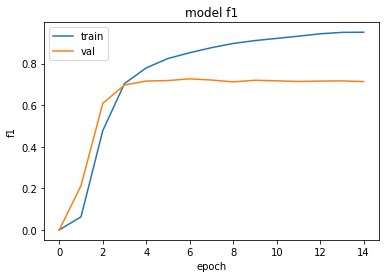

In [34]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Рекурретную сеть можно применить в прямом и обратном порядке и объединить состояния в одно (половина вектора будет про инфу до, половина про инфу после). Это назвается Bidirectional и делается в tf очень просто. 

In [36]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.LSTM(32, return_sequences=False)(lstm_1)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_2)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [37]:
model.summary()
# обратите внимание на размер output в biderectional
# он равен units * 2

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 200, 30)           1658820   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          162816    
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                36992     
_________________________________________________________________
dense_8 (Dense)              (None, 19)                627       
Total params: 1,859,255
Trainable params: 1,859,255
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/5
71/71 [==============================] - 34s 413ms/step - loss: 2.6258 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3365 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/5
71/71 [==============================] - 28s 396ms/step - loss: 2.3072 - f1: 0.0000e+00 - rec@prec: 1.1900e-05 - val_loss: 2.0172 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/5
71/71 [==============================] - 28s 396ms/step - loss: 1.9744 - f1: 0.0681 - rec@prec: 0.0036 - val_loss: 1.7839 - val_f1: 0.3001 - val_rec@prec: 0.0073
Epoch 4/5
71/71 [==============================] - 28s 393ms/step - loss: 1.7706 - f1: 0.3044 - rec@prec: 0.1013 - val_loss: 1.6943 - val_f1: 0.2924 - val_rec@prec: 0.1316
Epoch 5/5
71/71 [==============================] - 28s 397ms/step - loss: 1.5975 - f1: 0.3459 - rec@prec: 0.2302 - val_loss: 1.7022 - val_f1: 0.2606 - val_rec@prec: 0.2602


dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


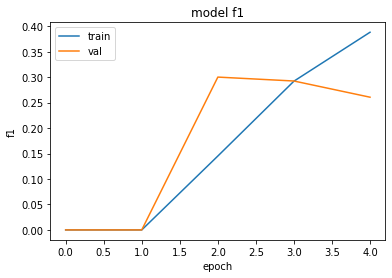

In [39]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Для простой классификации (когда мы используем только последний стейт) Bidirectional в таком виде не очень-то помогает (т.к. на последнем стейте у нас будет только первый стейт с обратного прохода). 

Можно отдельно прогнать RNN туда и обратно и последние стейты объединить (получится стейт, соответствующий последнему слову текста из прямого прохода и стейт, соответствующий первому слову в тексте из обратного прохода).


NB: когда мы оборачиваем LSTM в Bidirectional, то этот слой применяется и напрямую и обратно. Кажется, что логичнее иметь один слой для прямого прогона и один для обратного.
В Bidirectional можно также указать отдельный backward_layer, чтобы использовался новый слой.

In [54]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

# 1 слой на 2 прогона
# lstm = tf.keras.layers.LSTM(128, return_sequences=False)
# lstm_forward = lstm(embeddings)
# lstm_backward = lstm(embeddings[::-1])

# 2 слоя
lstm_forward =  tf.keras.layers.LSTM(128, return_sequences=False)(embeddings)
lstm_backward =  tf.keras.layers.LSTM(128, return_sequences=False, go_backwards=True)(embeddings)

hidden = tf.keras.layers.concatenate([lstm_forward, lstm_backward])

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(hidden)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [55]:
model.summary()
# обратите внимание на размер output в biderectional
# он равен units * 2

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 200, 30)      1658820     input_12[0][0]                   
__________________________________________________________________________________________________
lstm_18 (LSTM)                  (None, 128)          81408       embedding_11[0][0]               
__________________________________________________________________________________________________
lstm_19 (LSTM)                  (None, 128)          81408       embedding_11[0][0]               
___________________________________________________________________________________________

In [58]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=10)

Epoch 1/10
71/71 [==============================] - 23s 325ms/step - loss: 0.8136 - f1: 0.7534 - rec@prec: 0.7316 - val_loss: 1.2024 - val_f1: 0.6229 - val_rec@prec: 0.4902
Epoch 2/10
71/71 [==============================] - 23s 328ms/step - loss: 0.7640 - f1: 0.7643 - rec@prec: 0.7521 - val_loss: 1.0785 - val_f1: 0.7033 - val_rec@prec: 0.6068
Epoch 3/10
71/71 [==============================] - 23s 330ms/step - loss: 0.7098 - f1: 0.7887 - rec@prec: 0.7948 - val_loss: 1.0352 - val_f1: 0.7057 - val_rec@prec: 0.6196
Epoch 4/10
71/71 [==============================] - 23s 328ms/step - loss: 0.6751 - f1: 0.7991 - rec@prec: 0.8115 - val_loss: 0.9687 - val_f1: 0.7220 - val_rec@prec: 0.6633
Epoch 5/10
71/71 [==============================] - 24s 337ms/step - loss: 0.6204 - f1: 0.8168 - rec@prec: 0.8382 - val_loss: 1.0775 - val_f1: 0.7007 - val_rec@prec: 0.5880
Epoch 6/10
71/71 [==============================] - 24s 333ms/step - loss: 0.5726 - f1: 0.8324 - rec@prec: 0.8612 - val_loss: 1.0126 - 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


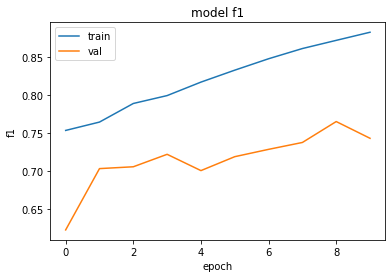

In [59]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Sequence labelling

На выходе из рекурректной сети мы получается по вектору на каждый элемент последовательности (состояние или hidden state). Мы можем использовать только последний, если нам нужно просто классифицировать весь текст (на последнем состоянии по идее должна была накопиться информация о все последовательности).

Кроме этого, мы можем классифицировать каждый элемент последовательности. Это называется sequence labelling (разметка последовательности). Под этот паттерн попадает предсказание части речи, определение именованных сущностей, определение опечаток и т.п.

Давайте попробуем предсказывать части речи.

Возьмем данные opencorpora

In [60]:
!curl http://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig.nonmod.xml.zip --output corpus.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6972k  100 6972k    0     0  13.1M      0 --:--:-- --:--:-- --:--:-- 13.1M


In [61]:
# http://opencorpora.org/files/export/annot/annot.opcorpora.xml.zip


In [62]:
!unzip corpus.xml

Archive:  corpus.xml
  inflating: annot.opcorpora.no_ambig.nonmod.xml  


In [63]:
!pip install lxml

     |████████████████████████████████| 6.3 MB 9.3 MB/s eta 0:00:01     |█████████▌                      | 1.9 MB 9.3 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [65]:
from lxml import etree
from collections import defaultdict

In [66]:
open_corpora = etree.fromstring(open('annot.opcorpora.no_ambig.nonmod.xml', 'rb').read())

Преобразуем в более удобный формат.

In [67]:
sents = []
labels = []


for sentence in open_corpora.xpath('//tokens'):
    length = len(sentence.xpath('token'))
    ended = False
    sent = []
    label = []
    for i,token in enumerate(sentence.xpath('token')):
        word = token.xpath('@text')
        gram_info = token.xpath('tfr/v/l/g/@v')
        
        if (i+1)==length and gram_info[0] == 'PNCT':
            gram_info = ['SENT']
            ended = True
        
            
        sent.append(word[0])
        label.append(gram_info[0])
    sents.append(sent)
    labels.append(label)

        

Пример данных

In [68]:
list(zip(sents[0], labels[0]))

[('«', 'PNCT'),
 ('Школа', 'NOUN'),
 ('злословия', 'NOUN'),
 ('»', 'PNCT'),
 ('учит', 'VERB'),
 ('прикусить', 'INFN'),
 ('язык', 'NOUN')]

In [69]:
# словарь
vocab = Counter()

for sent in sents:
    vocab.update([x.lower() for x in sent])

In [70]:
# тут словарь не очень большой и тут нужно предсказывать нужно часть речи для всего
# поэтому не будем фильтровать словарь
len(vocab)

54634

In [71]:
# индексируем слова
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

In [72]:
id2word = {i:word for word, i in word2id.items()}

In [73]:
# переводим тексты в последовательности индексов
X = []

for sent in sents:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [74]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')

Для частей речей нужно сделать то же самое.

In [102]:


tags = set()
for seq in labels:
    tags.update(seq)

label2id = {'PAD':0}
for tag in tags:
    label2id[tag] = len(label2id)

    
id2label = {i:l for l, i in label2id.items()}
tags = [id2label[i] for i in range(len(label2id))]

In [103]:
y = []

for seq in labels:
    
    ids = [label2id[label] for label in seq]
    y.append(ids)
    
y = tf.keras.preprocessing.sequence.pad_sequences(y, maxlen=MAX_LEN,  padding='post')

In [104]:
X_train, X_valid, y_train, y_valid = train_test_split(X, tf.keras.utils.to_categorical(y), test_size=0.05)

Еще y нужно пронать через ohe 

In [105]:
X_train.shape, y_train.shape

((24704, 230), (24704, 230, 30))

In [107]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(embeddings)

# чтобы классификация применялась к каждому стейту оборачиваем в TimeDistributed
# это как написать цикл и к каждому шагу применить Dense
outputs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(label2id), activation='softmax'))(lstm_1)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy')


In [108]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=128,
         epochs=5)

Epoch 1/5
193/193 [==============================] - 20s 88ms/step - loss: 0.4062 - val_loss: 0.0945
Epoch 2/5
193/193 [==============================] - 16s 82ms/step - loss: 0.0845 - val_loss: 0.0460
Epoch 3/5
193/193 [==============================] - 16s 83ms/step - loss: 0.0383 - val_loss: 0.0264
Epoch 4/5
193/193 [==============================] - 16s 83ms/step - loss: 0.0209 - val_loss: 0.0193
Epoch 5/5
193/193 [==============================] - 16s 82ms/step - loss: 0.0130 - val_loss: 0.0170


Оценивать предсказания последовательностей нужно отдельно. Лучше конечно еще оценивать правильность всей последовательности, но пока сделаем только поэлементную оценку.

In [112]:
from sklearn.metrics import classification_report

In [113]:
pred = model.predict(X_valid).argmax(2)

In [114]:
pred

array([[23, 21, 25, ...,  0,  0,  0],
       [25, 23, 20, ...,  0,  0,  0],
       [25, 25,  0, ...,  0,  0,  0],
       ...,
       [25, 27, 17, ...,  0,  0,  0],
       [ 7, 25, 25, ...,  0,  0,  0],
       [25,  7,  5, ...,  0,  0,  0]])

In [124]:
print(classification_report(y_valid.argmax(2).reshape(-1), pred.reshape(-1), labels=list(range(30)),
                                                                             target_names=tags,
                                                                             zero_division=0))

              precision    recall  f1-score   support

         PAD       1.00      1.00      1.00    286638
        HANI       0.00      0.00      0.00         3
        ADVB       0.83      0.85      0.84       261
        ADJF       0.82      0.81      0.81      1171
        PRTF       0.27      0.28      0.27        65
        NPRO       0.97      0.95      0.96       299
        GREK       0.00      0.00      0.00         7
        PREP       1.00      0.99      1.00      1201
        Prnt       0.00      0.00      0.00         0
        PRTS       0.88      0.45      0.60        77
        PRCL       0.94      0.94      0.94       207
        GRND       0.33      0.03      0.05        35
        DATE       0.00      0.00      0.00         1
        INFN       0.61      0.65      0.63       205
        TIME       0.00      0.00      0.00         1
        COMP       1.00      0.19      0.32        26
        ROMN       1.00      0.50      0.67        12
        SENT       1.00    

# Предсказание/Inference

После оценки часто хочется посмотреть как будет работать модель на каких-то отдельных примерах. Для этого нужно воспрозвести весь пайплайн и прогонять через него нужный текст.

In [129]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 0) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [130]:
label_seq('Какой-то новый текст для проверки работы.', word2id, id2label, MAX_LEN, model)

[('Какой', 'ADJF'),
 ('-', 'PNCT'),
 ('то', 'CONJ'),
 ('новый', 'ADJF'),
 ('текст', 'NOUN'),
 ('для', 'PREP'),
 ('проверки', 'NOUN'),
 ('работы', 'NOUN'),
 ('.', 'SENT')]